In [ ]:
# Dependencies
!pip install -q monai nibabel matplotlib scikit-learn
import torch, os, random, numpy as np, nibabel as nib, matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from monai.losses import DiceLoss
from monai.networks.nets import UNet
from monai.metrics import DiceMetric

random.seed(42); np.random.seed(42); torch.manual_seed(42)
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon GPU)")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using MPS (Apple Silicon GPU)


In [ ]:
# Dataset
root_dir = "./data/BraTS2021_Training_Data"

class BraTS2DFLAIR(Dataset):
    def __init__(self, root_dir, case_list, bg_keep_prob=0.15):
        self.root_dir = root_dir
        self.case_list = case_list
        self.bg_keep_prob = bg_keep_prob
        
        # preload volumes
        self.data = []
        print(f"Loading {len(case_list)} cases…")
        
        for case in case_list:
            seg_path   = os.path.join(root_dir, case, f"{case}_seg.nii.gz")
            flair_path = os.path.join(root_dir, case, f"{case}_flair.nii.gz")

            flair = nib.load(flair_path).get_fdata().astype(np.float32)
            seg   = nib.load(seg_path).get_fdata().astype(np.float32)

            mask = (seg > 0).astype(np.float32)

            self.data.append((flair, mask))

        # slice indexing
        print("Building slice index…")
        self.indices = []
        for case_idx, (_, mask) in enumerate(self.data):
            for z in range(mask.shape[2]):
                if mask[:, :, z].any() or random.random() < bg_keep_prob:
                    self.indices.append((case_idx, z))

        print(f"Total indexed slices: {len(self.indices)}")

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        case_idx, z = self.indices[idx]
        flair, mask = self.data[case_idx]

        img  = flair[:, :, z]
        m    = mask[:, :, z]

        img = (img - img.mean()) / (img.std() + 1e-8)

        img = torch.tensor(img[None], dtype=torch.float32)
        m   = torch.tensor(m[None], dtype=torch.float32)
        return img, m


# Patient-wise split
all_cases = [f for f in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, f)) and not f.startswith(".")]
random.shuffle(all_cases)
limited_cases = all_cases[:500]

split_idx = int(0.90 * len(limited_cases))
train_cases, val_cases = limited_cases[:split_idx], limited_cases[split_idx:]

print(f"Total patients: {len(all_cases)}")
print(f"Train patients: {len(train_cases)} | Val patients: {len(val_cases)}")

train_ds = BraTS2DFLAIR(root_dir, train_cases, bg_keep_prob=0.15)
val_ds   = BraTS2DFLAIR(root_dir, val_cases,   bg_keep_prob=0.15)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  drop_last=True, num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=0)

Total patients: 1251
Train patients: 450 | Val patients: 50
Loading 450 cases…
Building slice index…
Total indexed slices: 34864
Loading 50 cases…
Building slice index…
Total indexed slices: 4133


In [6]:
# Device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using:", device)

torch.set_float32_matmul_precision("high")

# Model
model = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(32, 64, 128, 256, 512),
    strides=(2, 2, 2, 2),
    num_res_units=2,
)

criterion = DiceLoss(sigmoid=True)

# Move to device
model = model.to(device)
criterion = criterion.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)


Using: mps


In [ ]:
# Training (20 epochs)
n_epochs = 20
best_dice = 0.0
history = {"train_loss": [], "val_dice": []}
dice_metric = DiceMetric(include_background=True, reduction="mean")

for epoch in range(1, n_epochs + 1):
    model.train()
    epoch_loss = 0.0
    for img, mask in train_loader:
        img, mask = img.to(device), mask.to(device)
        pred = model(img)
        loss = criterion(pred, mask)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    scheduler.step()

    model.eval()
    dice_metric.reset()
    with torch.no_grad():
        for img, mask in val_loader:
            img, mask = img.to(device), mask.to(device)
            pred = model(img)
            pred = torch.sigmoid(pred)
            dice_metric(pred, mask)

    val_dice = dice_metric.aggregate().item()


    history["train_loss"].append(epoch_loss / len(train_loader))
    history["val_dice"].append(val_dice)
    if val_dice > best_dice:
        best_dice = val_dice
        torch.save(model.state_dict(), "brats2021_flair_2d_best.pth")

    print(f"Epoch {epoch:02d}/20 | Train loss: {history['train_loss'][-1]:.4f} | Val Dice: {val_dice:.4f} | Best: {best_dice:.4f}")
print(f"\nTraining completed. Best validation Dice: {best_dice:.4f}")

Epoch 01/20 | Train loss: 0.7148 | Val Dice: 0.7249 | Best: 0.7249
Epoch 02/20 | Train loss: 0.3683 | Val Dice: 0.7079 | Best: 0.7249
Epoch 03/20 | Train loss: 0.3424 | Val Dice: 0.7649 | Best: 0.7649
Epoch 04/20 | Train loss: 0.3282 | Val Dice: 0.7942 | Best: 0.7942
Epoch 05/20 | Train loss: 0.3194 | Val Dice: 0.7830 | Best: 0.7942
Epoch 06/20 | Train loss: 0.3134 | Val Dice: 0.7862 | Best: 0.7942
Epoch 07/20 | Train loss: 0.3047 | Val Dice: 0.7757 | Best: 0.7942
Epoch 08/20 | Train loss: 0.2996 | Val Dice: 0.8127 | Best: 0.8127
Epoch 09/20 | Train loss: 0.2937 | Val Dice: 0.8097 | Best: 0.8127
Epoch 10/20 | Train loss: 0.2817 | Val Dice: 0.7661 | Best: 0.8127
Epoch 11/20 | Train loss: 0.2533 | Val Dice: 0.7842 | Best: 0.8127
Epoch 12/20 | Train loss: 0.2113 | Val Dice: 0.7803 | Best: 0.8127
Epoch 13/20 | Train loss: 0.2095 | Val Dice: 0.7740 | Best: 0.8127
Epoch 14/20 | Train loss: 0.1872 | Val Dice: 0.7405 | Best: 0.8127
Epoch 15/20 | Train loss: 0.1831 | Val Dice: 0.7768 | Best: 0.

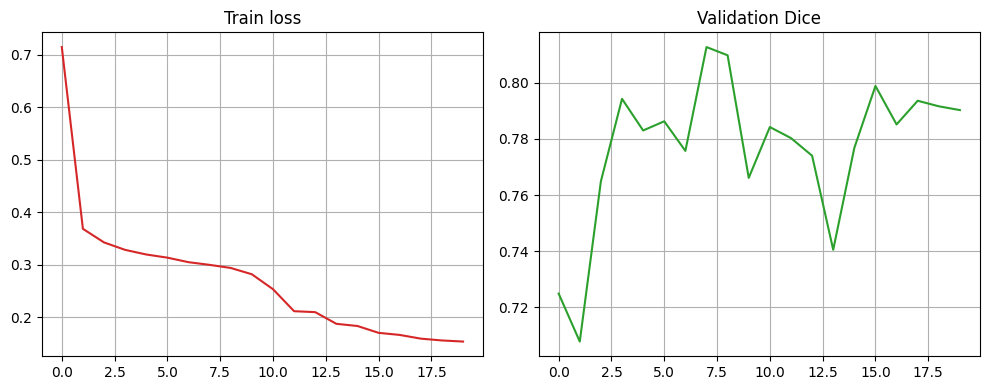

In [ ]:
# Learning curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(history["train_loss"], color="tab:red"); plt.title("Train loss"); plt.grid(True)
plt.subplot(1,2,2); plt.plot(history["val_dice"], color="tab:green"); plt.title("Validation Dice"); plt.grid(True)
plt.tight_layout(); plt.show()

Dataset Statistics
Number of 3D cases used: 500
Total 2D slices: 38997
Train slices: 34864, Validation slices: 4133
Slices with tumor: 32148 (82.4%)
Background-only slices: 6849 (17.6%)


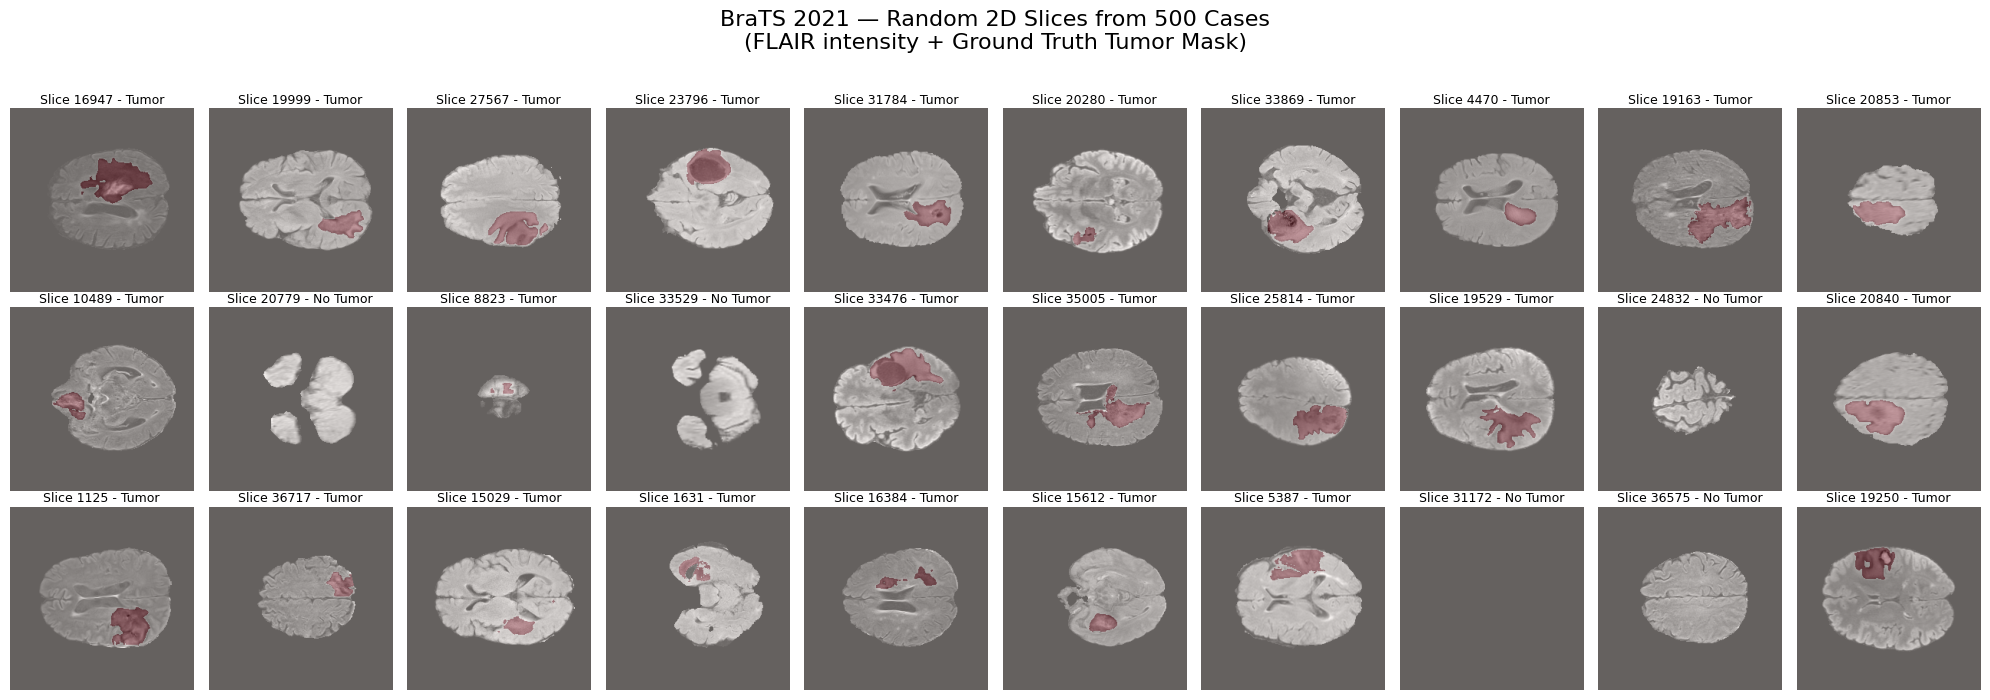

In [14]:
# # Dataset Analysis + Visualization 
# import matplotlib.pyplot as plt
# import random

# from numpy import full

full_ds = torch.utils.data.ConcatDataset([train_ds, val_ds])

print("Dataset Statistics")
print(f"Number of 3D cases used: 500")
print(f"Total 2D slices: {len(full_ds)}")
print(f"Train slices: {len(train_ds)}, Validation slices: {len(val_ds)}")

# Re-calculate tumor vs background 
tumor_slices = 0
bg_slices = 0
for i in range(len(full_ds)):
    mask = full_ds[i][1]
    if mask.sum() > 0:
        tumor_slices += 1
    else:
        bg_slices += 1

print(f"Slices with tumor: {tumor_slices} ({tumor_slices/len(full_ds)*100:.1f}%)")
print(f"Background-only slices: {bg_slices} ({bg_slices/len(full_ds)*100:.1f}%)")

# Visualization
fig, axs = plt.subplots(3, 10, figsize=(20, 7))
fig.suptitle("BraTS 2021 — Random 2D Slices from 500 Cases\n(FLAIR intensity + Ground Truth Tumor Mask)", fontsize=16, y=1.003)

random_indices = random.sample(range(len(full_ds)), 30)

for i, idx in enumerate(random_indices):
    row = i // 10
    col = i % 10
    
    img_tensor, mask_tensor = full_ds[idx]
    img = img_tensor[0].numpy()    # (240, 240)
    mask = mask_tensor[0].numpy()  # (240, 240)

    axs[row, col].imshow(img, cmap='gray')
    axs[row, col].imshow(mask, cmap='Reds', alpha=0.4)
    
    axs[row, col].set_title(
        f"Slice {idx} - " + ("Tumor" if mask.sum() > 0 else "No Tumor"),
        fontsize=9, pad=4
    )
    axs[row, col].axis('off')


plt.tight_layout()
plt.subplots_adjust(top=0.87)
plt.show()

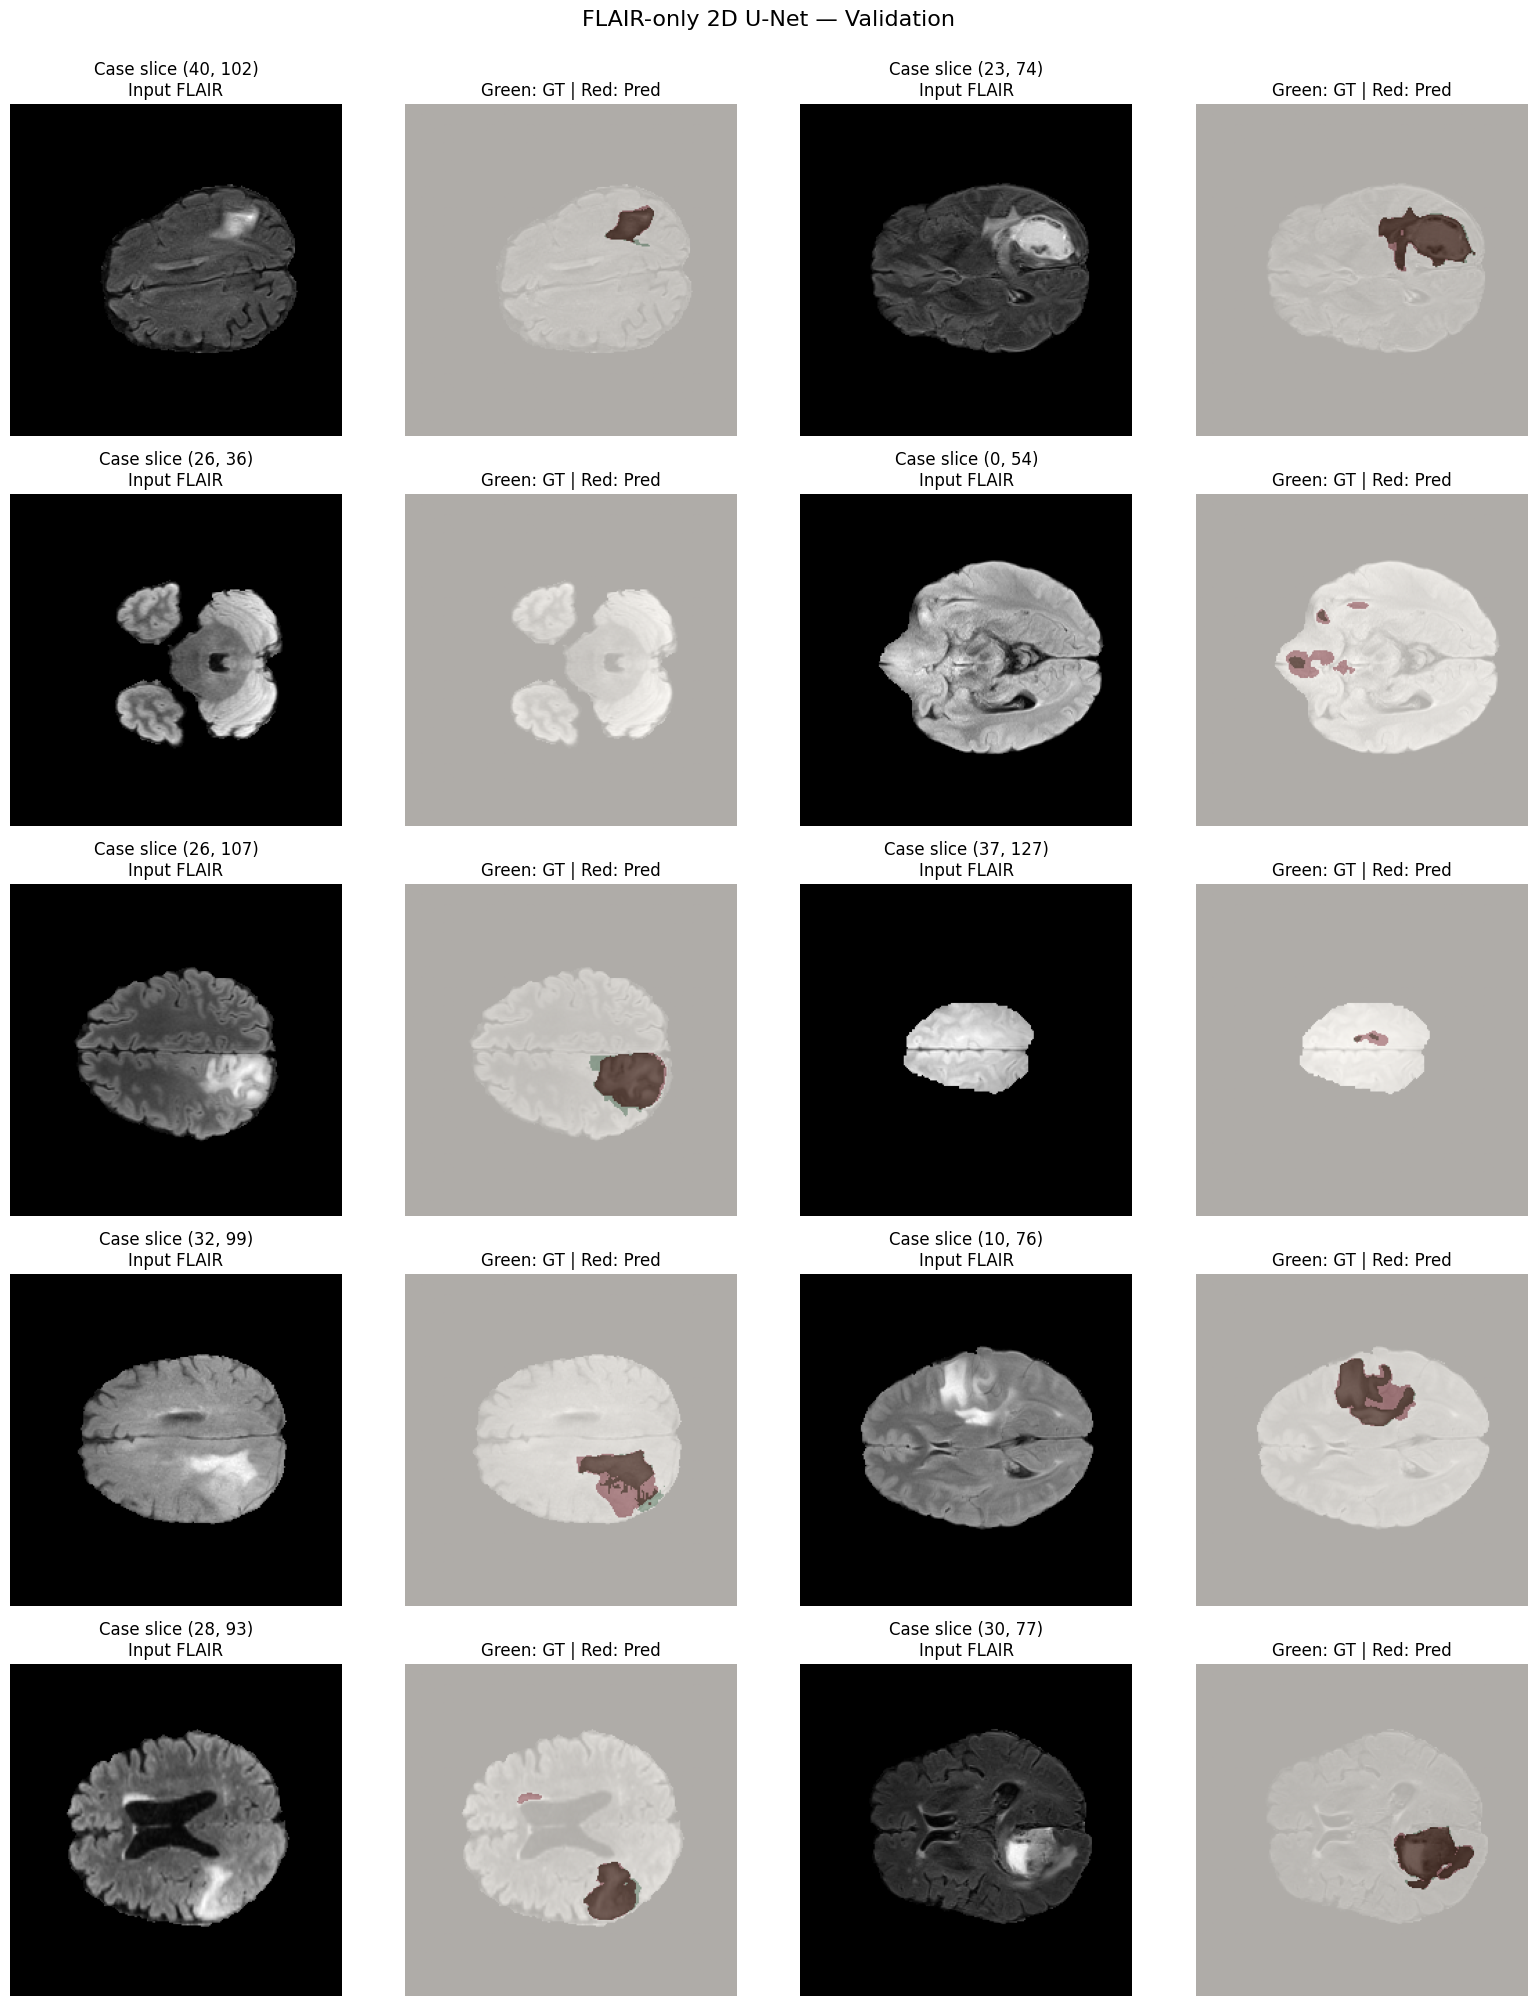

In [13]:
# Visualisation on validation set
model.eval()
model.load_state_dict(torch.load("brats2021_flair_2d_best.pth", map_location=device))
indices = random.sample(range(len(val_ds)), 10)

fig, axs = plt.subplots(5, 4, figsize=(16,20))
fig.suptitle("FLAIR-only 2D U-Net — Validation", fontsize=16, y=1.0005)

with torch.no_grad():
    for i, idx in enumerate(indices):
        img, gt = val_ds[idx]
        pred = torch.sigmoid(model(img.unsqueeze(0).to(device)))[0,0].cpu().numpy()
        pred_bin = (pred > 0.5).astype(np.float32)

        axs[i//2, (i%2)*2].imshow(img[0], cmap='gray')
        axs[i//2, (i%2)*2].set_title(f"Case slice {val_ds.indices[idx]}\nInput FLAIR")
        axs[i//2, (i%2)*2].axis('off')

        ax = axs[i//2, 2*(i%2)+1]
        ax.imshow(img[0], cmap="gray")
        ax.imshow(gt[0], cmap="Greens", alpha=0.5)
        ax.imshow(pred_bin, cmap="Reds", alpha=0.4)
        ax.set_title("Green: GT | Red: Pred"); ax.axis("off")

plt.tight_layout(); plt.show()